In [1]:
%load_ext nb_black

<IPython.core.display.Javascript object>

In [2]:
from src.env import *
from src.imports import *
from src.config import *
from src.dataset import *
from src.metric import *

Found cached dataset generator (C:/tempjeka/cache/huggingface/generator/default-f628ff2f2d994b84/0.0.0)
Loading cached split indices for dataset at C:\tempjeka\cache\huggingface\generator\default-f628ff2f2d994b84\0.0.0\cache-a84cfc0a0e11ed54.arrow and C:\tempjeka\cache\huggingface\generator\default-f628ff2f2d994b84\0.0.0\cache-665145fe0a5a6a51.arrow
Loading cached split indices for dataset at C:\tempjeka\cache\huggingface\generator\default-f628ff2f2d994b84\0.0.0\cache-e104a2bffe25c7fa.arrow and C:\tempjeka\cache\huggingface\generator\default-f628ff2f2d994b84\0.0.0\cache-4096519e2393e19f.arrow


<IPython.core.display.Javascript object>

In [3]:
enc_name = "t5-base"
model_name = "t5-base"

<IPython.core.display.Javascript object>

In [4]:
enc_tokenizer = AutoTokenizer.from_pretrained(enc_name)

C:\tempjeka\anaconda3\lib\site-packages\transformers\models\t5\tokenization_t5_fast.py:155: FutureWarning: This tokenizer was incorrectly instantiated with a model max length of 512 which will be corrected in Transformers v5.
For now, this behavior is kept to avoid breaking backwards compatibility when padding/encoding with `truncation is True`.
- Be aware that you SHOULD NOT rely on t5-base automatically truncating your input to 512 when padding/encoding.
- If you want to encode/pad to sequences longer than 512 you can either instantiate this tokenizer with `model_max_length` or pass `max_length` when encoding/padding.
- To avoid this warning, please instantiate this tokenizer with `model_max_length` set to your preferred value.
  warnings.warn(


<IPython.core.display.Javascript object>

In [5]:
dec_tokenizer = enc_tokenizer

<IPython.core.display.Javascript object>

In [ ]:
def create_dataset(
    enc_tokenizer: AutoTokenizer, dec_tokenizer: AutoTokenizer | None = None
) -> Dataset:
    if dec_tokenizer is None:
        dec_tokenizer = enc_tokenizer

    def preprocess_function(batch):
        inputs = enc_tokenizer(
            [(prefix + ex[source_lang]).strip() for ex in batch["translation"]]
        )
        outputs = dec_tokenizer(
            [ex[target_lang].strip() for ex in batch["translation"]]
        )

        batch["input_ids"] = inputs.input_ids
        batch["attention_mask"] = inputs.attention_mask
        batch["labels"] = outputs.input_ids.copy()

        batch["input_ids_length"] = [len(row) for row in batch["input_ids"]]
        batch["labels_length"] = [len(row) for row in batch["labels"]]

        return batch

    dataset = DatasetDict(
        dict(train=test["train"], val=val["train"], test=val["test"])
    ).map(preprocess_function, batched=True, batch_size=batch_size)
    dataset.set_format(
        type="torch",
        columns=["input_ids", "attention_mask", "labels"],
    )
    return dataset


In [6]:
dataset = create_dataset(enc_tokenizer, dec_tokenizer).sort("input_ids_length")

Map:   0%|          | 0/45000 [00:00<?, ? examples/s]

Map:   0%|          | 0/50 [00:00<?, ? examples/s]

Map:   0%|          | 0/4950 [00:00<?, ? examples/s]

<IPython.core.display.Javascript object>

In [17]:
from transformers import AutoModel

model = AutoModelForSeq2SeqLM.from_pretrained(model_name)

<IPython.core.display.Javascript object>

In [18]:
model.config.max_length = max_input_length
model.config.min_length = 10
model.config.no_repeat_ngram_size = 3
model.config.early_stopping = True
model.config.num_beams = 10

<IPython.core.display.Javascript object>

In [19]:
version = 0

<IPython.core.display.Javascript object>

In [20]:
version += 1
args = Seq2SeqTrainingArguments(
    output_dir=Path("models") / model_name,
    evaluation_strategy="steps",
    learning_rate=5e-5,
    #     lr_scheduler_type="constant_with_warmup",
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    save_total_limit=1,
    num_train_epochs=4,
    predict_with_generate=True,
    warmup_steps=3000,
    fp16=True,
    logging_dir=f"../made/logs/lightning_logs/{model_name}/{version}",
    logging_first_step=False,
    eval_steps=1000,
    logging_steps=500,
    overwrite_output_dir=True,
    group_by_length=True,
)

<IPython.core.display.Javascript object>

In [21]:
trainer = Seq2SeqTrainer(
    model=model,
    args=args,
    compute_metrics=partial(compute_metrics, dec_tokenizer, metric),
    train_dataset=dataset["train"],
    eval_dataset=dataset["val"],
    data_collator=DataCollatorForSeq2Seq(dec_tokenizer, model=model),
)

<IPython.core.display.Javascript object>

In [22]:
trainer.train()

Step,Training Loss,Validation Loss,Bleu,Gen Len
1000,2.015800,1.528383,0.066738,55.320000
2000,1.513600,1.131535,0.084826,58.560000
3000,1.264000,0.915143,0.145160,59.480000
4000,1.087800,0.775548,0.144813,61.480000
5000,0.952900,0.692699,0.166467,63.640000
6000,0.884800,0.622082,0.186846,67.740000
7000,0.819300,0.565756,0.196174,67.440000
8000,0.795600,0.528743,0.174652,65.100000
9000,0.749700,0.490764,0.214067,69.840000
10000,0.706600,0.460989,0.227377,69.260000


C:\tempjeka\anaconda3\lib\site-packages\transformers\generation\utils.py:1219: UserWarning: You have modified the pretrained model configuration to control generation. This is a deprecated strategy to control generation and will be removed soon, in a future version. Please use a generation configuration file (see https://huggingface.co/docs/transformers/main_classes/text_generation)
  warnings.warn(
IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 

TrainOutput(global_step=45000, training_loss=0.6541544101291232, metrics={'train_runtime': 13753.6169, 'train_samples_per_second': 13.087, 'train_steps_per_second': 3.272, 'total_flos': 4687767356497920.0, 'train_loss': 0.6541544101291232, 'epoch': 4.0})

<IPython.core.display.Javascript object>

In [23]:
model.save_pretrained(model_name)

<IPython.core.display.Javascript object>

In [7]:
model = EncoderDecoderModel.from_pretrained(model_name)

<IPython.core.display.Javascript object>

In [35]:
# dataset["train"][100]
# dec_tokenizer.decode(dataset["train"][100]["labels"])
dec_tokenizer.get_vocab()

{'▁holes': 8034,
 'IG': 8834,
 '▁1969': 17185,
 '▁chronic': 6658,
 '▁officiel': 25822,
 '▁fishing': 5095,
 'side': 1583,
 'naire': 9671,
 'uca': 18283,
 '▁détour': 30748,
 '▁colleagues': 6976,
 'pan': 2837,
 'CE': 4770,
 '▁videos': 3075,
 'langage': 29098,
 '▁apărut': 20719,
 'cream': 11763,
 '▁wake': 7178,
 '▁herzlich': 19044,
 '▁drive': 1262,
 '▁spots': 6883,
 '▁overwhelmed': 18940,
 'Mag': 22909,
 '▁Citi': 17795,
 '▁evident': 6843,
 '▁boulder': 30904,
 '▁Sunday': 1771,
 '▁MI': 8161,
 '▁tied': 10422,
 '▁Does': 3520,
 '▁paste': 11388,
 '▁diligence': 23206,
 'enko': 18994,
 '▁loading': 12115,
 'western': 24411,
 'character': 31886,
 '▁Queen': 5286,
 '▁paper': 1040,
 '▁implications': 12418,
 '▁refuz': 19352,
 'affecting': 13403,
 'Algérie': 30790,
 '▁Trouble': 31520,
 '▁viaţă': 19313,
 'cît': 24365,
 'ație': 6395,
 '▁whistle': 23585,
 '▁lassen': 3363,
 '▁Wednesday': 2875,
 '-18': 6996,
 '▁humble': 15084,
 '▁réservé': 28341,
 '▁Ste': 3557,
 'expo': 19300,
 '▁hole': 6356,
 '▁egg': 6182,
 

<IPython.core.display.Javascript object>

In [27]:
metric = evaluate.load("bleu")
model.cuda()
model.eval()
with torch.no_grad():
    dataset["test"].map(
        partial(
            compute_metrics_test,
            model,
            DataCollatorWithPadding(enc_tokenizer),
            dec_tokenizer,
            metric,
            log=False,
        ),
        batched=True,
        batch_size=batch_size,
    )

Map:   0%|          | 0/4950 [00:00<?, ? examples/s]

<IPython.core.display.Javascript object>

In [29]:
metric.compute()

{'bleu': 0.06259804100769788,
 'precisions': [0.3441169104756854,
  0.10384389251720139,
  0.04291060864766044,
  0.016179215930304917],
 'brevity_penalty': 0.886969042872506,
 'length_ratio': 0.8929008326427529,
 'translation_length': 67881,
 'reference_length': 76023}

<IPython.core.display.Javascript object>

In [25]:
metric = evaluate.load("bleu")
model.cuda()
model.eval()
_idx = 100
with torch.no_grad():
    dataset["test"].select(range(_idx, _idx + 16)).map(
        partial(
            compute_metrics_test,
            model,
            DataCollatorWithPadding(enc_tokenizer),
            dec_tokenizer,
            metric,
            log=True,
        ),
        batched=True,
        batch_size=batch_size,
    )
metric.compute()

Map:   0%|          | 0/16 [00:00<?, ? examples/s]

[{'input': 'Some have 2 balconies.',
  'target': ['В некоторых апартаментах есть 2 балкона.'],
  'preds': 'некотор номера ест 2 алкон.'},
 {'input': 'Reservations are strongly recommended.',
  'target': ['Настоятельно рекомендуется бронировать столики заранее.'],
  'preds': 'роме тоо, остм редоставлтс вомоности на аросу.'},
 {'input': 'Parking is free of charge.',
  'target': ['На территории предоставляется бесплатная парковка.'],
  'preds': 'арковка редоставлетс еслатно.'},
 {'input': 'Free WiFi access is available.',
  'target': ['К услугам гостей бесплатный Wi-Fi.'],
  'preds': 'услуам осте еслатн Wi-Fi.'}]

[{'input': 'Free WiFi access is provided.',
  'target': ['Гости могут пользоваться бесплатным Wi-Fi.'],
  'preds': 'услуам осте еслатн Wi-Fi.'},
 {'input': 'Free WiFi is offered .',
  'target': ['К услугам гостей бесплатный Wi-Fi.'],
  'preds': 'услуам осте еслатн Wi-Fi.'},
 {'input': 'The property offers free parking.',
  'target': ['Гостям предоставляется бесплатная парковка.'],
  'preds': 'устроена еслатна арковка.'},
 {'input': 'Free private parking is available.',
  'target': ['Имеется бесплатная частная парковка.'],
  'preds': 'втомоил моно оставит на еслатно соственно арковке.'}]

[{'input': 'The property offers free parking.',
  'target': ['На территории отеля обустроена бесплатная парковка.'],
  'preds': 'устроена еслатна арковка.'},
 {'input': 'There are also 2 bathrooms.',
  'target': ['В числе удобств 2 ванные комнаты.'],
  'preds': 'расорении осте 2 ванне комнат.'},
 {'input': 'The property offers free parking.',
  'target': ['Обустроена бесплатная парковка.'],
  'preds': 'устроена еслатна арковка.'},
 {'input': 'BBQ equipment is also available.',
  'target': ['Предоставляются принадлежности для барбекю.'],
  'preds': 'роме тоо, ости моут восоловатс удоствами дл арек.'}]

[{'input': 'The property offers free parking.',
  'target': ['На территории обустроена бесплатная парковка.'],
  'preds': 'устроена еслатна арковка.'},
 {'input': 'The property offers free parking.',
  'target': ['Гости могут воспользоваться бесплатной парковкой.'],
  'preds': 'устроена еслатна арковка.'},
 {'input': 'Towels are available.',
  'target': ['Предоставляются полотенца.'],
  'preds': 'остм редоставлтс олотена.'},
 {'input': 'Towels are featured.',
  'target': ['Кроме того, предоставляются полотенца.'],
  'preds': 'остм редоставлтс олотена.'}]

{'bleu': 0.0,
 'precisions': [0.2441860465116279, 0.04285714285714286, 0.0, 0.0],
 'brevity_penalty': 0.9435182845371068,
 'length_ratio': 0.945054945054945,
 'translation_length': 86,
 'reference_length': 91}

<IPython.core.display.Javascript object>

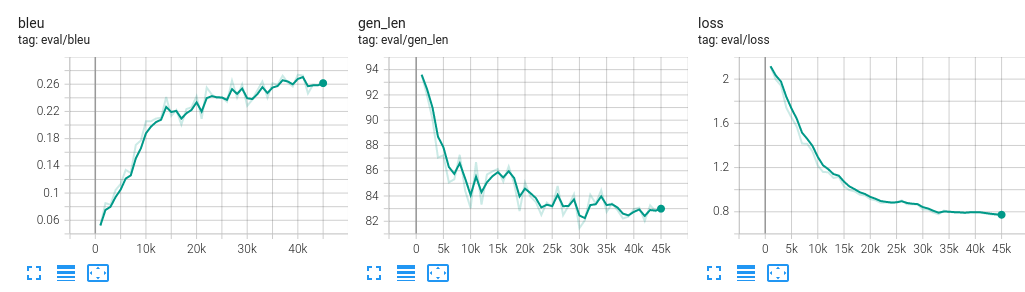 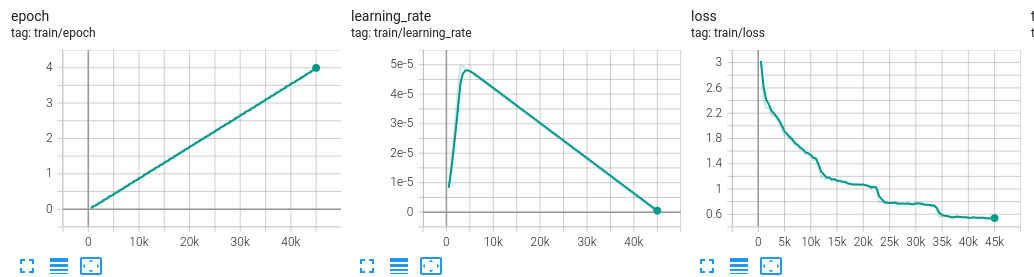